# Adquisición de los datos
Descarga de los datos. Hago el GET y lo copio en un archivo 'EEGEyeState.arff'

In [1]:
import os.path
import urllib.request
import shutil

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00264/EEG%20Eye%20State.arff'
file_name = 'EEGEyeState.arff'

# Si el archivo no existe o tiene tamaño 0, lo bajo
if not os.path.exists(file_name) or os.stat(file_name).st_size <= 0:
    with urllib.request.urlopen(url) as response, open(file_name, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)

# Analisis inicial y detección de outliers

Cargo los datos del archivo arff y los convierto a dataframe.
Hago describe para dar un vistazo a los datos. 
Los máximos de algunas variables (AF3, FC5, P7, O1, P8, F8, AF4) están sumamente lejos de las medias. Es probable que hayan outliers en el dataset.
La media de eyeDetection está cercana a 0.5 así que es un dataset balanceado (i.e: no hay mucho más etiquetas de una categoría que de otra)

In [2]:
from scipy.io import arff
import pandas as pd
data, meta = arff.loadarff(file_name)
data = pd.DataFrame(data)
# Convierto la columna final a entero
data["eyeDetection"] = data["eyeDetection"].astype('int')
data.describe()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
count,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000
mean,4321.917777,4009.767694,4264.022433,4164.946326,4341.741075,4644.022379,4110.400160,4616.056904,4218.826610,4231.316200,4202.456900,4279.232774,4615.205336,4416.435832,0.448798
std,2492.072174,45.941672,44.428052,5216.404632,34.738821,2924.789537,4600.926543,29.292603,2136.408523,38.050903,37.785981,41.544312,1208.369958,5891.285043,0.497388
min,1030.770000,2830.770000,1040.000000,2453.330000,2089.740000,2768.210000,2086.150000,4567.180000,1357.950000,1816.410000,3273.330000,2257.950000,86.666700,1366.150000,0.000000
25%,4280.510000,3990.770000,4250.260000,4108.210000,4331.790000,4611.790000,4057.950000,4604.620000,4190.770000,4220.510000,4190.260000,4267.690000,4590.770000,4342.050000,0.000000
50%,4294.360000,4005.640000,4262.560000,4120.510000,4338.970000,4617.950000,4070.260000,4613.330000,4199.490000,4229.230000,4200.510000,4276.920000,4603.080000,4354.870000,0.000000
75%,4311.790000,4023.080000,4270.770000,4132.310000,4347.180000,4626.670000,4083.590000,4624.100000,4209.230000,4239.490000,4211.280000,4287.180000,4617.440000,4372.820000,1.000000
max,309231.000000,7804.620000,6880.510000,642564.000000,6474.360000,362564.000000,567179.000000,7264.100000,265641.000000,6674.360000,6823.080000,7002.560000,152308.000000,715897.000000,1.000000


Aplico 3 técnicas de detección de outliers no paramétricas (a priori no sabemos nada de las variables que componen los datos) aptas para datos de alta dimensión.
One Class SVM, Isolation Forest y Local Outlier Factor. Encontradas en: http://scikit-learn.org/stable/modules/outlier_detection.html
Clasifico un dato como outlier si 2 de los 3 métodos lo detectan como tal.

In [3]:
import numpy as np
from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# Semilla aleatoria para resultados reproducibles
rng = np.random.RandomState(42)
factorContaminacion = 0.5/100 # Arbitrario pero conservador, 0.5% de los datos se consideran outliers, se podría ajustar mejor

cOneClassSVM = svm.OneClassSVM(nu=1 - factorContaminacion, kernel="rbf", gamma=0.1, random_state=rng)
cIsolationForest = IsolationForest(contamination=factorContaminacion, random_state=rng, n_jobs=-1)
cLocalOutlierFactor = LocalOutlierFactor(n_neighbors=35, contamination=factorContaminacion, n_jobs=-1)

# Ajusta los modelos y calcula las etiquetas de cada dato para cada método. Demora unos minutos
cOneClassSVM.fit(X=data)
cIsolationForest.fit(X=data)
esOutlier = np.column_stack((cOneClassSVM.predict(X=data), cIsolationForest.predict(X=data), cLocalOutlierFactor.fit_predict(X=data))) == -1
esOutlier = esOutlier.sum(axis=1) >= 2

19 valores fueron detectados como outliers por la combinación de métodos

In [4]:
esOutlier.sum()

19

Quitando los outliers los máximos se ven más razonables. Además, las desviaciones de las variables afectadas disminuyen notoriamente.

In [5]:
validData = data[~esOutlier]
validData.describe()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
count,14961.000000,14961.000000,14961.000000,14961.000000,14961.000000,14961.000000,14961.000000,14961.000000,14961.000000,14961.000000,14961.000000,14961.000000,14961.000000,14961.000000,14961.000000
mean,4301.284253,4009.425433,4263.989699,4122.285475,4341.471710,4619.957046,4072.741916,4615.703193,4201.255304,4231.107323,4202.053115,4278.997516,4605.915226,4361.214690,0.449302
std,37.657989,29.974471,21.091153,20.701946,16.724244,18.166280,20.737372,18.110231,17.599426,19.500633,24.246670,19.854582,33.271561,38.374001,0.497440
min,4197.950000,3905.640000,4197.440000,4058.460000,4304.620000,4566.150000,4026.150000,4567.180000,4147.690000,4152.820000,4100.000000,4201.030000,4443.080000,4205.640000,0.000000
25%,4280.510000,3990.770000,4250.260000,4108.210000,4331.790000,4611.790000,4057.950000,4604.620000,4190.770000,4220.510000,4190.260000,4267.690000,4590.770000,4342.050000,0.000000
50%,4294.360000,4005.640000,4262.560000,4120.510000,4338.970000,4617.950000,4070.260000,4613.330000,4199.490000,4229.230000,4200.510000,4276.920000,4603.080000,4354.870000,0.000000
75%,4311.790000,4023.080000,4270.770000,4132.310000,4347.180000,4626.670000,4083.590000,4624.100000,4209.230000,4239.490000,4211.280000,4287.180000,4617.440000,4372.820000,1.000000
max,4504.100000,4156.920000,4386.150000,4250.260000,4463.590000,4756.920000,4178.460000,4731.790000,4320.000000,4362.560000,4332.310000,4394.870000,4833.850000,4573.330000,1.000000


Mirando los histogramas las variables parecen razonablemente gaussianas. Vamos a usar escalado con media y desviación estandar

[[<matplotlib.axes._subplots.AxesSubplot object at 0x000002217A91EA20>


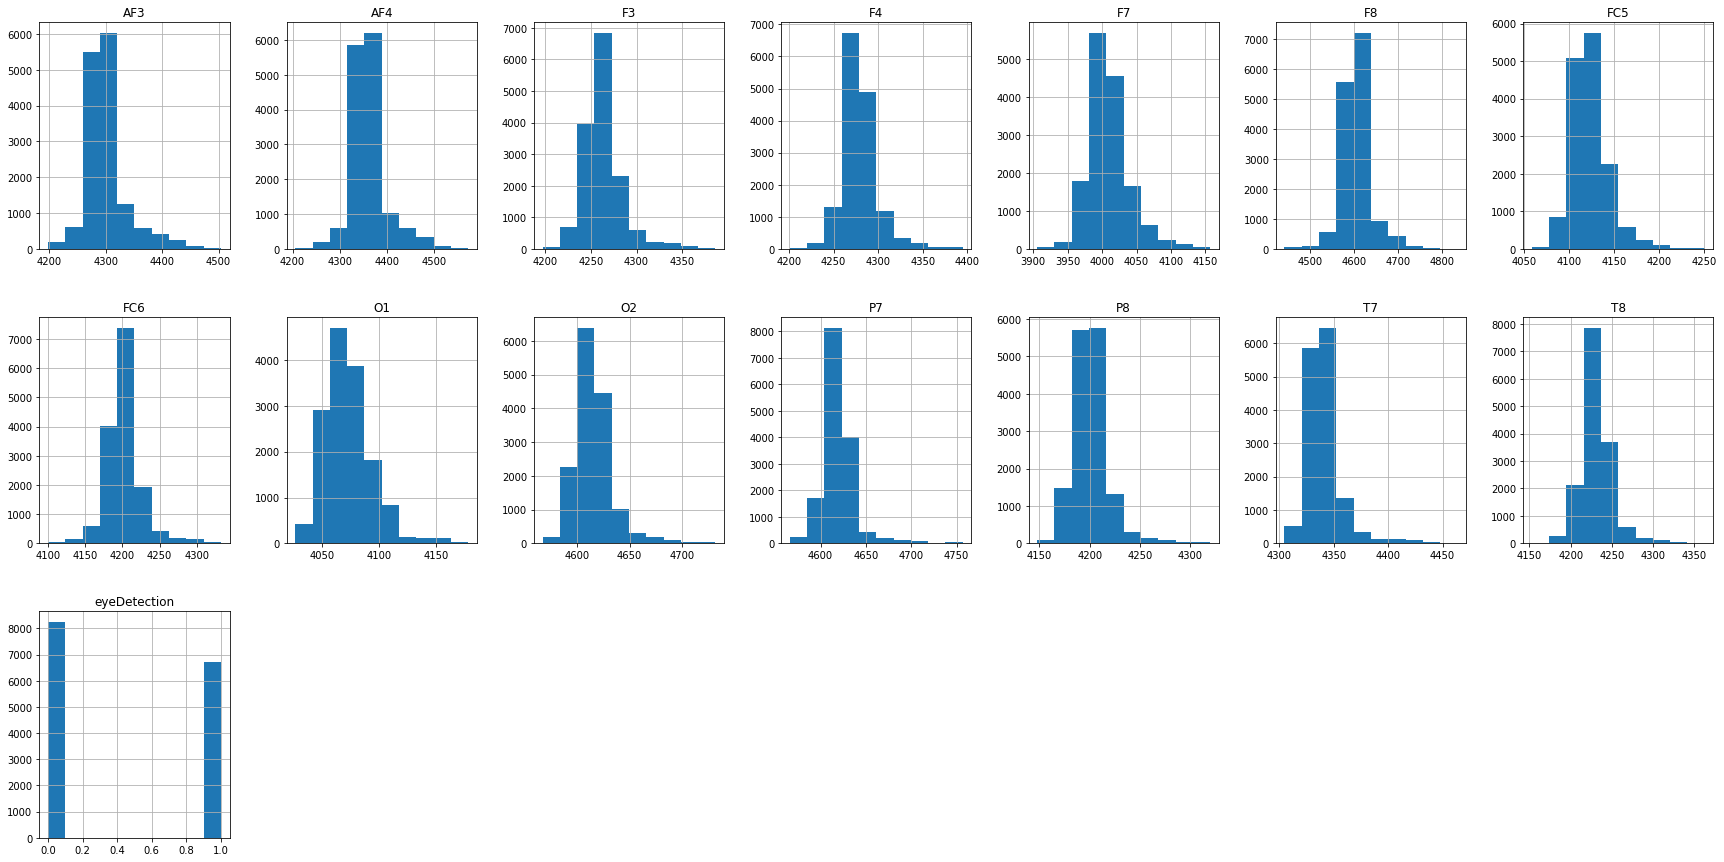

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

print(validData.hist(layout=(3, 7), figsize=(30, 15)))

# Conjuntos de entrenamiento y validación

Divido los datos en un conjunto de entrenamiento (66.6% de la población) y validación (33.3%)

In [9]:
from sklearn.model_selection import train_test_split

# Labels are the values we want to predict
labels = np.array(validData['eyeDetection'])

# Remove the labels from the features
# axis 1 refers to the columns
features= validData.drop('eyeDetection', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 1/3, random_state = rng)

# Clasificador Binario con el Algoritmo K*
En el paper en: http://suendermann.com/su/pdf/aihls2013.pdf el algoritmo que encuentra los mejores resultados es este K*, por lo que fue mi primer intento de solucionar el problema.
Me cree un usuario en WEKA, conecté a la API con mi key, logré hacer que un llamado de ejemplo anduviera pero cuando lo voy a correr para el problema real me falla con un error de la clase genérica de la API (AlgorithmException) indicando que podría haber un timeout o un out-of-memory.
Intenté aumentar el timeout a 50 minutos (el máximo que permite) pero no anduvo y la verdad no encontré mucho para donde seguir con el problema. No parecen ser muchos datos como para quedarse sin memoria. En este momento la página de la documentación del algoritmo en: http://weka.sourceforge.net/doc.stable/weka/classifiers/lazy/KStar.html me está dando un mensaje de error de que los servidores de sourceforge están experimentando un tráfico anormal, quizás pueda venir por ahí el problema.

In [64]:
import Algorithmia

# Cambio el blend a 40 (-B 40) ya que fue el valor que mejores resultados dio en el paper
input = {
  "trainUrl": "data://ludecan/EEG_Eye_State/EEGEyeState.arff",
  "cv": 3,
  "options": "-B 40",
  "mode": "train",
  "modelUrl": "data://ludecan/EEG_Eye_State/model.txt"
}
client = Algorithmia.client('simqPUoVE90RoKHLf+4idN9o5Sc1')
algo = client.algo('weka/KStar/0.1.1')
algo = algo.set_options(timeout=3000)

print(algo.pipe(input).result)

AlgorithmException: 'Failed to run algorithm - may have timed-out or hit out-of-memory error'

# Clasificador Binario con Deep Learning
Escalamiento de los datos

In [10]:
from sklearn import preprocessing

# Escalo los conjuntos de datos usando la media y escala del conjunto de entrenamiento
scaler = preprocessing.StandardScaler().fit(train_features)
sc_train_features = scaler.transform(train_features)
sc_test_features = scaler.transform(test_features)

Creo un MLP con dos capas ocultas de 64 unidades cada una. Activación relu y agrego capas de dropout para evitar overfitting.
Como medida de precisión vamos a usar accuracy.

In [13]:
import tensorflow as tf
from tensorflow import keras

# Limpio la sesion de TensorFlow para empezar con un modelo de 0
tf.keras.backend.clear_session()
dl = keras.Sequential()

dl.add(keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(14,)))
dl.add(keras.layers.Dropout(0.5))
dl.add(keras.layers.Dense(64, activation=tf.nn.relu))
dl.add(keras.layers.Dropout(0.5))
dl.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

dl.compile(optimizer='SGD',
           loss='binary_crossentropy',
           metrics=['accuracy'])

Entrenamiento del modelo. Le pongo 500 epochs como para que pueda evolucionar pero a su vez le pongo un callback de early stopping, para que no siga avanzando si
no hay mejoras en la función de pérdida.
Le pongo verbose = 0 para que no quede demasiado texto hacia abajo, si se quiere seguir el avance del entrenamiento poner verbose =1

In [14]:
history = dl.fit(sc_train_features,
                 train_labels,
                 epochs=500,
                 batch_size=128,
                 callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          min_delta=0,
                                                          patience=3,
                                                          verbose=0, mode='auto')],
                 validation_data=(sc_test_features, test_labels),
                 verbose=0)

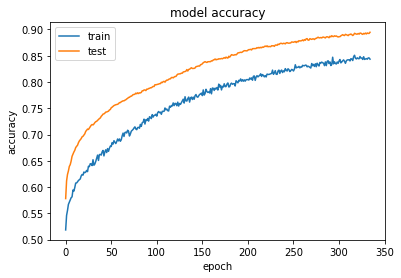

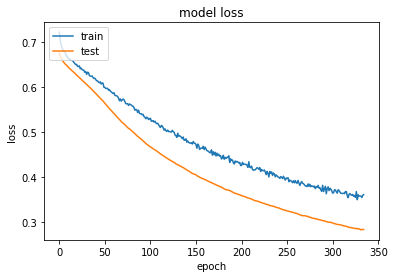

In [15]:
# gráfico de accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# gráfico de función de pérdida
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
predictions_dl = dl.predict_classes(sc_test_features)

# Clasificador Binario con Bosques Aleatorios
Creo un clasificador de random forest y lo entreno con los datos de entrenamiento

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators= 100, random_state=rng, n_jobs=-1)
rf.fit(train_features, train_labels);

predictions_rf = rf.predict(test_features)

## Importancia de variables

Obtengo la importancia de las variables según el modelo ajustado
En este caso O1, P7, F7, AF3, F8 y AF4 parecen ser las más significativas y las demás un poco menos.
No lo hago ahora pero se podría plantear un clasificador con las variables más importantes y ver como se comportan las métricas de precisión

Variable: O1                   Importancia: 0.12
Variable: P7                   Importancia: 0.1
Variable: F7                   Importancia: 0.09
Variable: AF3                  Importancia: 0.08
Variable: F8                   Importancia: 0.08
Variable: AF4                  Importancia: 0.08
Variable: FC5                  Importancia: 0.06
Variable: O2                   Importancia: 0.06
Variable: T8                   Importancia: 0.06
Variable: FC6                  Importancia: 0.06
Variable: F4                   Importancia: 0.06
Variable: F3                   Importancia: 0.05
Variable: T7                   Importancia: 0.05
Variable: P8                   Importancia: 0.05


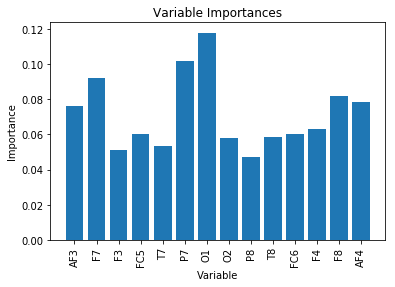

In [17]:
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importancia: {}'.format(*pair)) for pair in feature_importances];

x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 

# Evaluación de los modelos
Calculamos para cada modelo su accuracy y matriz de confusión

## Evaluación de Deep Learning

In [18]:
from sklearn.metrics import accuracy_score

predictions_dl = np.transpose(predictions_dl)[0]

accuracy_score(test_labels, predictions_dl)

0.8947262883497092

In [19]:
pd.crosstab(test_labels, predictions_dl, rownames=['Observaciones'], colnames=['Predicciones'])

Predicciones,0,1
Observaciones,,
0,2582,221
1,304,1880


## Evaluación de Bosques Aleatorios

In [20]:
accuracy_score(test_labels, predictions_rf)

0.9304190896330459

In [21]:
pd.crosstab(test_labels, predictions_rf, rownames=['Observaciones'], colnames=['Predicciones'])

Predicciones,0,1
Observaciones,,
0,2672,131
1,216,1968


# Conclusión
De los algoritmos aplicados que si funcionaron, random forest (RF) obtuvo una accuracy un poco mayor (0.93 vs 0.89) y mejores resultados en todas las celdas de la matriz de confusión por lo que para este caso resulta ganador. Sería interesante probar variantes del RF, como la versión con las variables más importantes, redes con arquitecturas más complejas e incluso hacer funcionar el K* y volver a comparar los resultados.